In [164]:
import numpy as np
from mnist import MNIST
import umap

from sklearn.datasets import make_blobs
from scipy.spatial import distance_matrix
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import rc
from matplotlib.colors import ListedColormap
matplotlib.rcParams['figure.dpi'] = 360
matplotlib.rcParams['text.usetex'] = True
rc("animation", html = "jshtml")
plt.style.use('dark_background')

from astropy.table import Table as t
from astropy.io import fits
import pygwalker as pyg

import os
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']

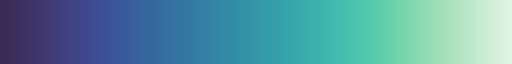

In [165]:
cmap = sns.color_palette("mako", as_cmap=True)
col = cmap(np.linspace(0.2, 1.0, 256))
cmap = ListedColormap(col)
cmap

### Example mnist

In [166]:
mndata = MNIST('/Users/valeriatorresgomez/fashion-mnist/data/fashion')
train, train_labels = mndata.load_training()
test, test_labels = mndata.load_testing()
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.hstack([train_labels, test_labels])
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

In [167]:
%time
embedding = umap.UMAP(n_neighbors=5).fit_transform(data)

CPU times: user 2 μs, sys: 2 μs, total: 4 μs
Wall time: 6.2 μs


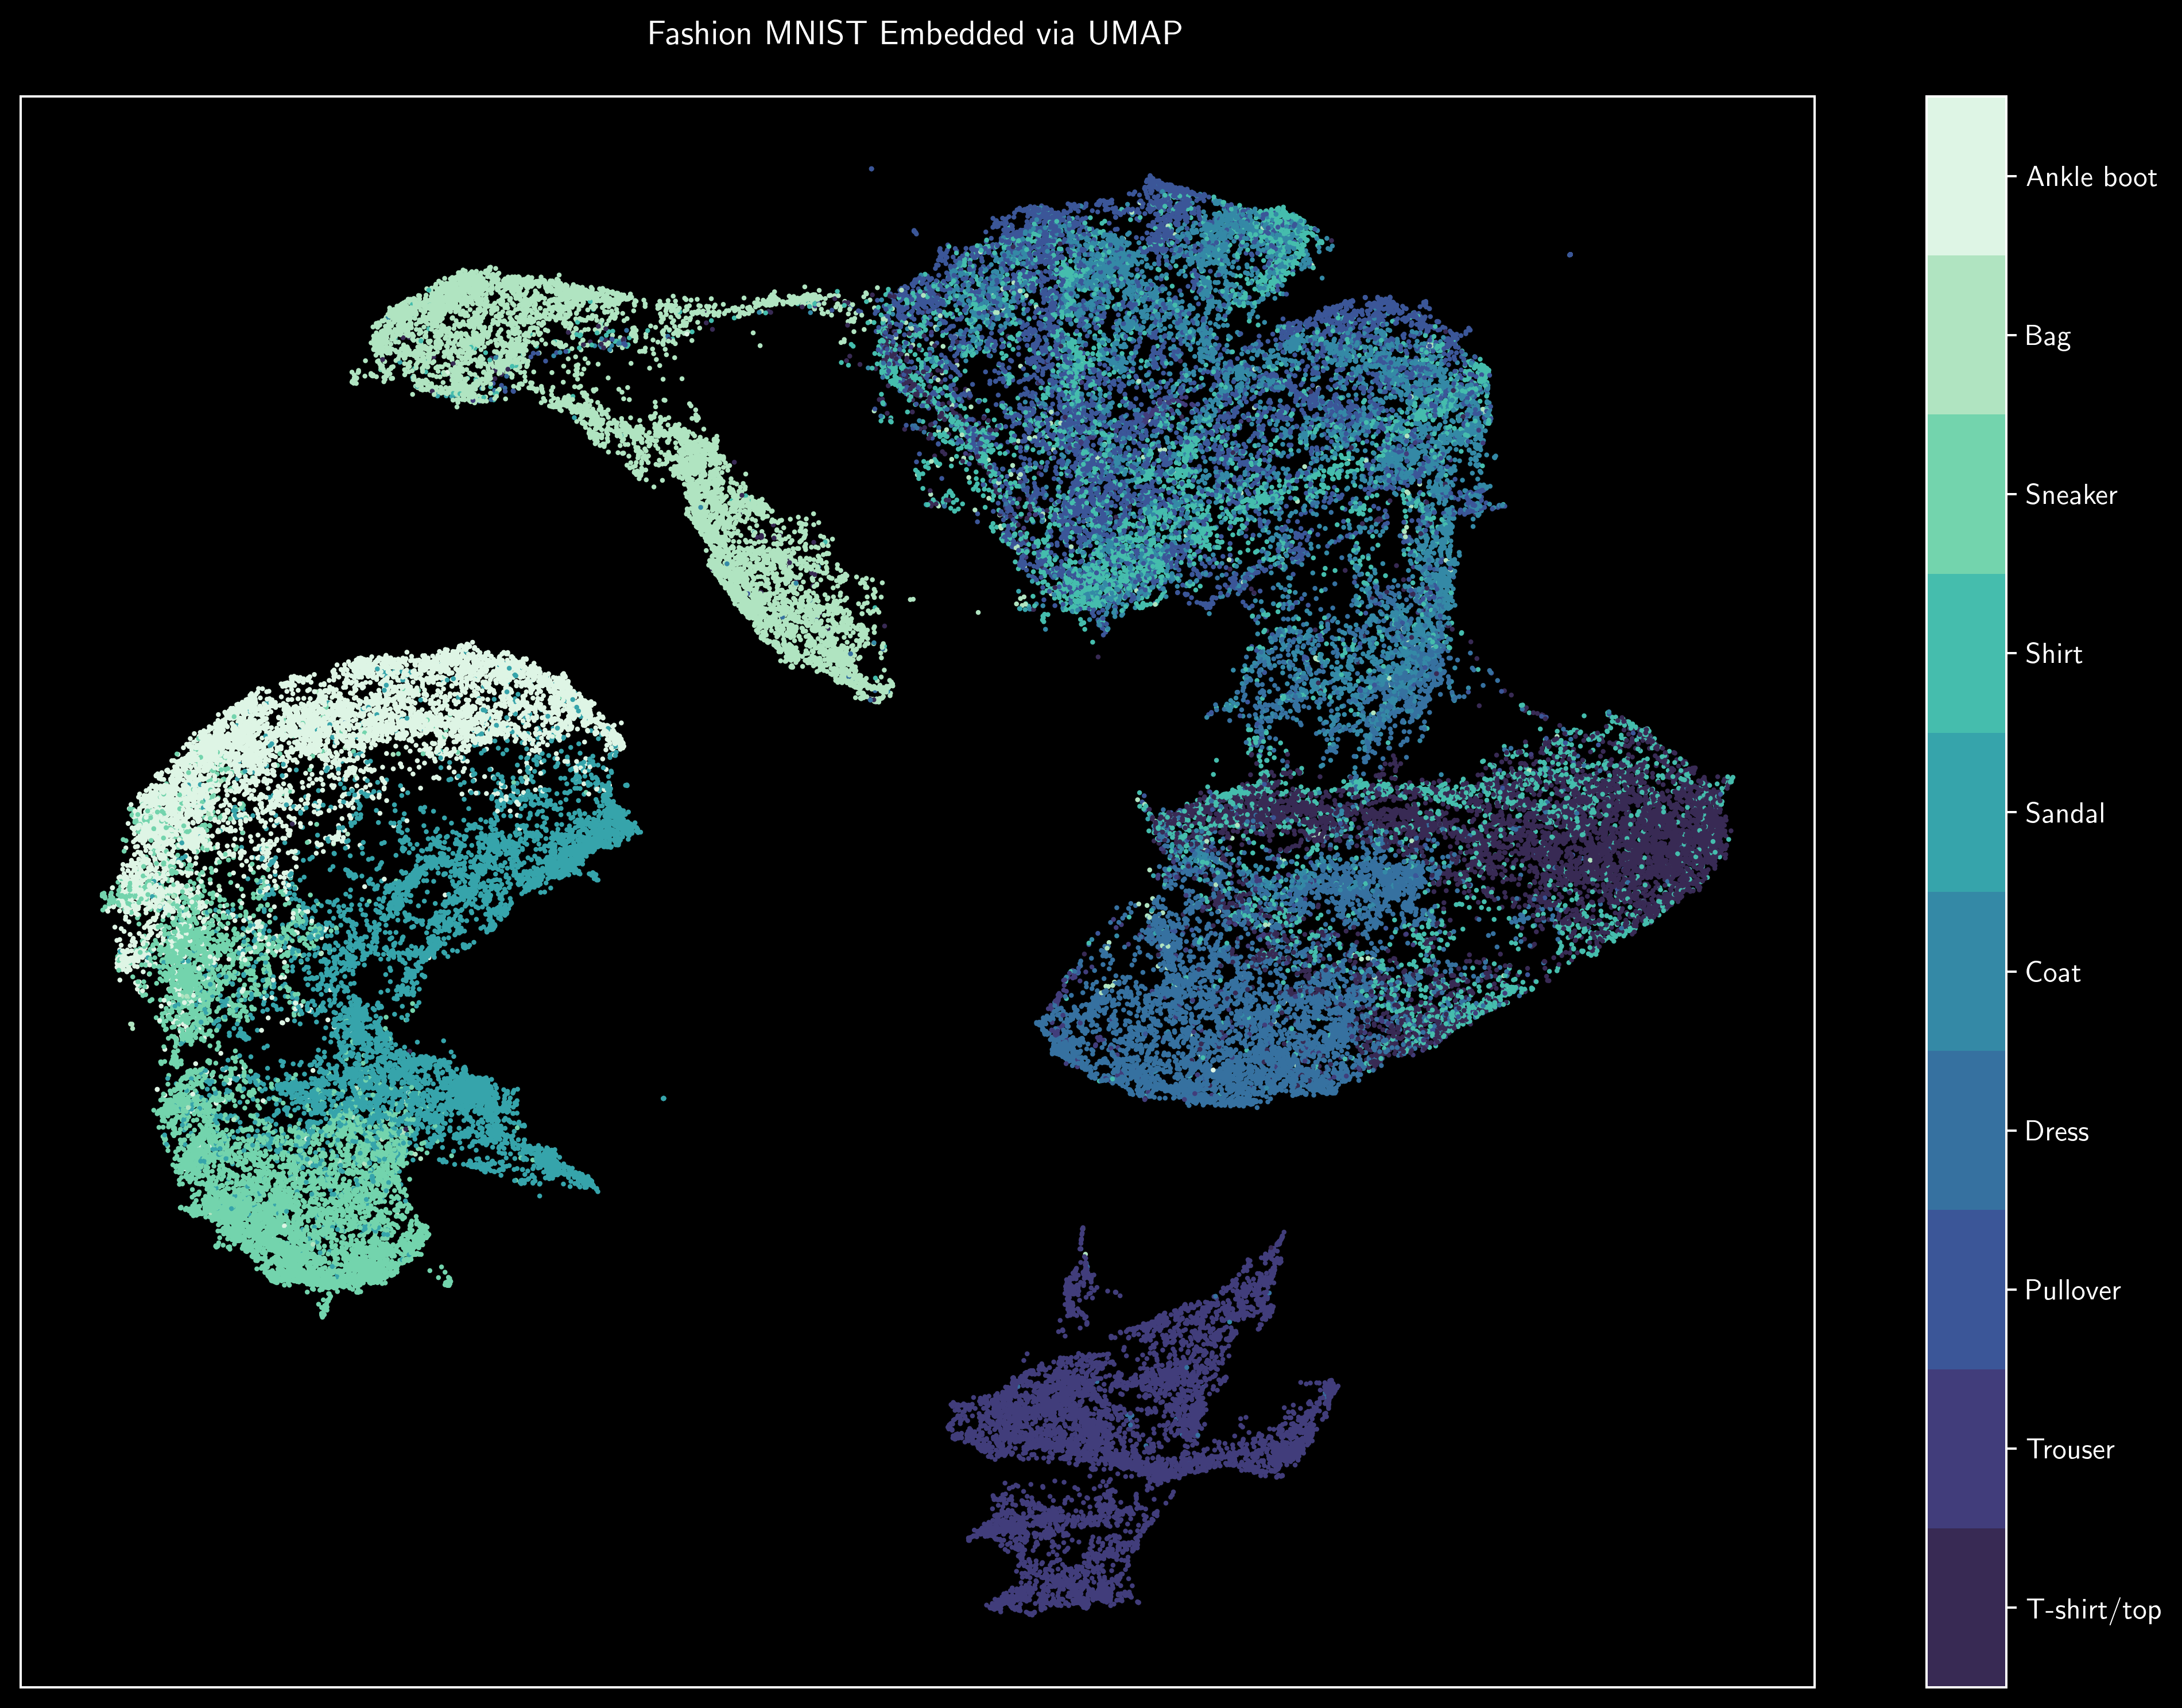

In [172]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.5, c=target, cmap=cmap, alpha=1.0, zorder=1)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP\n');

In [173]:
%%time
embedding = umap.UMAP().fit_transform(data, y=target)

CPU times: user 2min 17s, sys: 1min 9s, total: 3min 26s
Wall time: 37.3 s


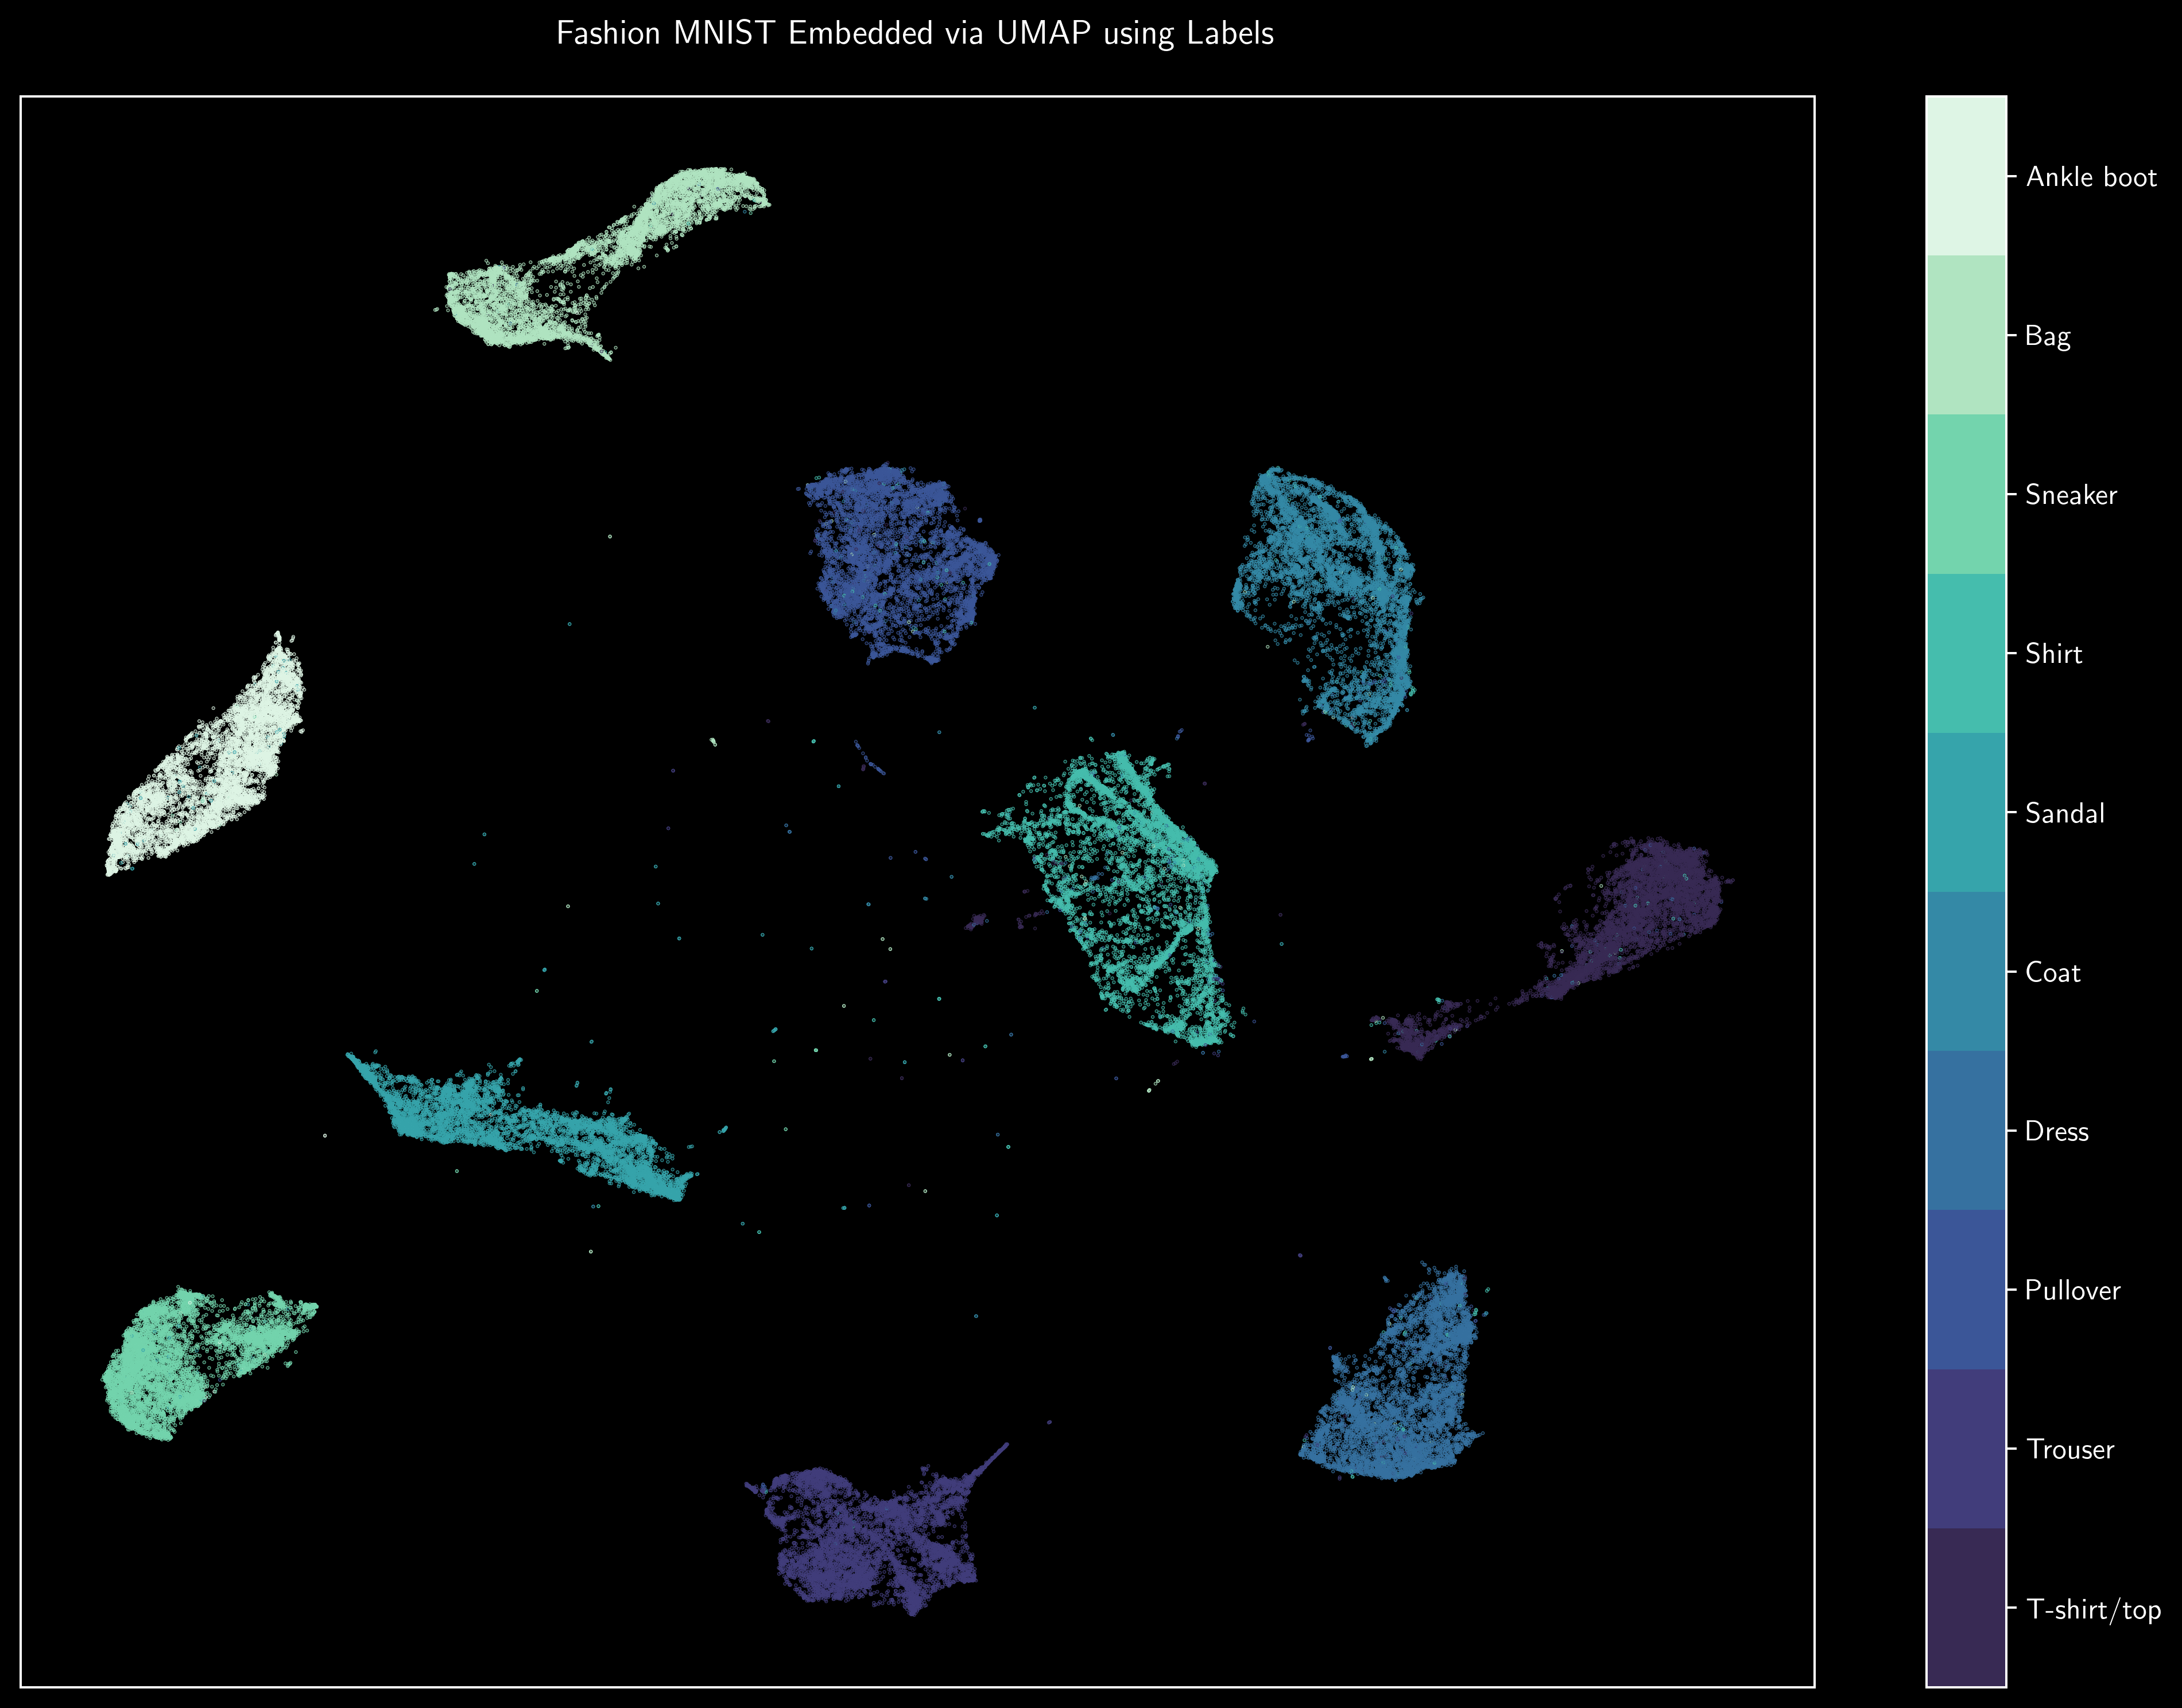

In [174]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.05, c=target, cmap=cmap, alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.grid(lw=0.5)
plt.title('Fashion MNIST Embedded via UMAP using Labels\n');

### Using FoF

In [146]:
n_inliers = 500
n_features = 10
n_clusters = 5
cluster_std = 4.0  #std

X_inliers, _ = make_blobs(n_samples=n_inliers,
                          n_features=n_features,
                          centers=n_clusters,
                          cluster_std=cluster_std,)

In [147]:
n_outliers = 400
X_outliers = np.random.uniform(low=-20, high=20, size=(n_outliers, n_features))

X = np.vstack([X_inliers, X_outliers])

In [148]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

/usr/local/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [149]:
linking_length = 0.3

dist_matrix = distance_matrix(embedding, embedding)

adjacency = (dist_matrix < linking_length) & (dist_matrix > 0)

adjacency_sparse = csr_matrix(adjacency)

n_components, labels = connected_components(csgraph=adjacency_sparse, directed=False, return_labels=True)
print(f'clusters: {n_components}')

clusters: 34


In [150]:
min_cluster_size = 5
unique_labels, counts = np.unique(labels, return_counts=True)
small_clusters = unique_labels[counts < min_cluster_size]

is_outlier = np.isin(labels, small_clusters)

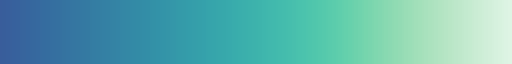

In [189]:
cmap = sns.color_palette("mako", as_cmap=True)
col = cmap(np.linspace(0.4, 1.0, 256))
cmap = ListedColormap(col)
cmap

In [152]:
unique_clusters = np.unique(labels[~is_outlier])
n_clusters = len(unique_clusters)

colors = [cmap(i / n_clusters) for i in range(n_clusters)]

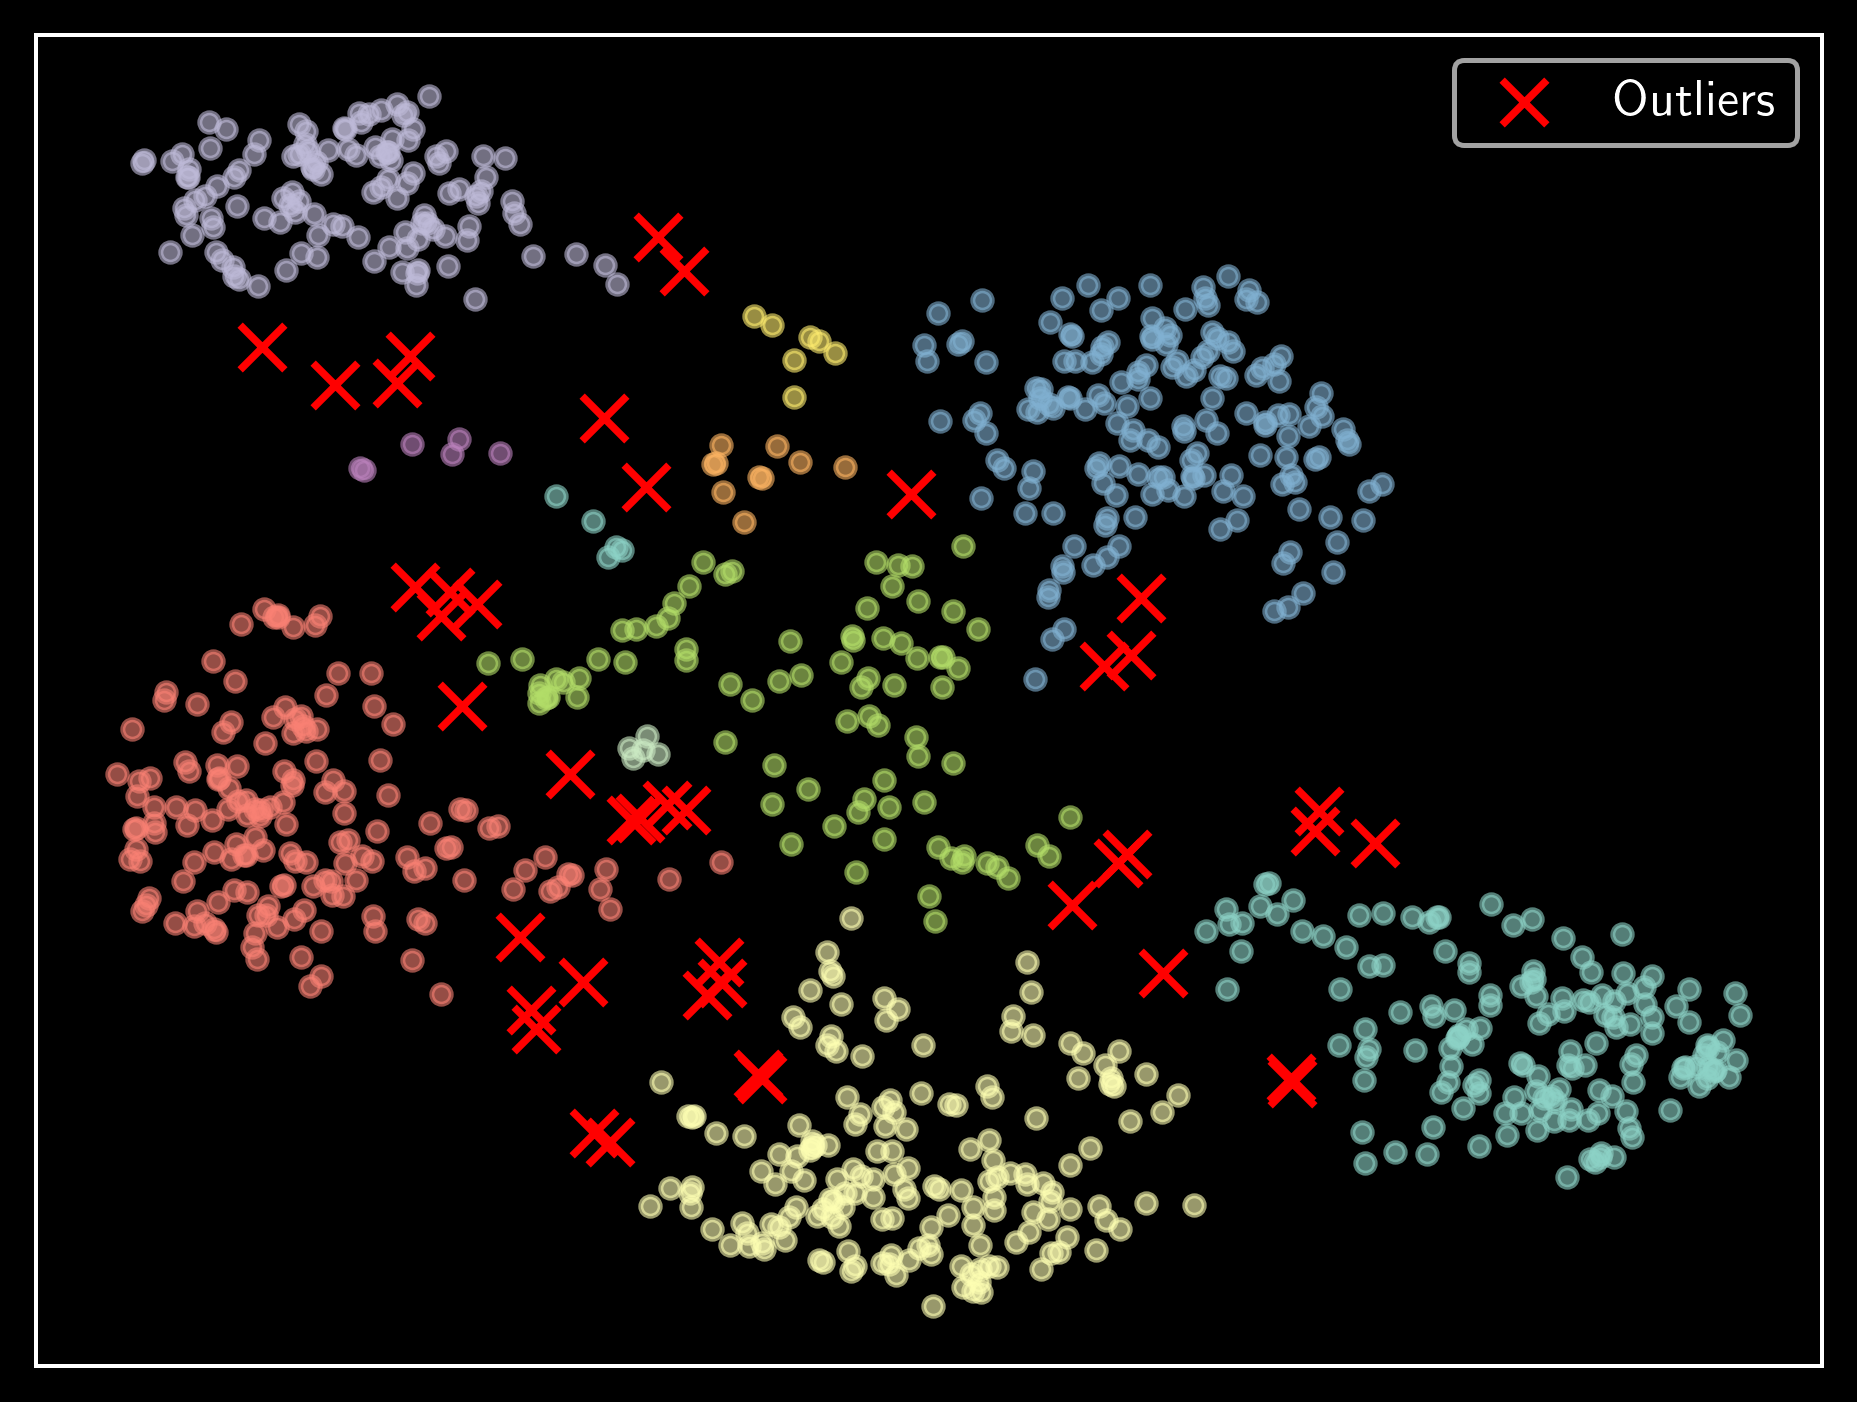

In [154]:
plt.figure()

for i, cl in enumerate(np.unique(labels[~is_outlier])):
    mask = labels == cl
    plt.scatter(embedding[mask, 0], embedding[mask, 1], alpha=0.6, s=15)#, label=f'Cluster {cl}',)

if np.sum(is_outlier) > 0:
    plt.scatter(embedding[is_outlier, 0], embedding[is_outlier, 1],
                color='red', marker='x', s=80, label='Outliers')

# plt.title('Random UMAP/FoF\n')
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

clusters: 12


/var/folders/bl/gg6nr0r53rlb_243x6jlv_rr0000gn/T/ipykernel_95318/1678859711.py:44: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embedding[mask, 0], embedding[mask, 1], alpha=0.6, s=15, c=colors[i])#, label=f'Cluster {cl}',)


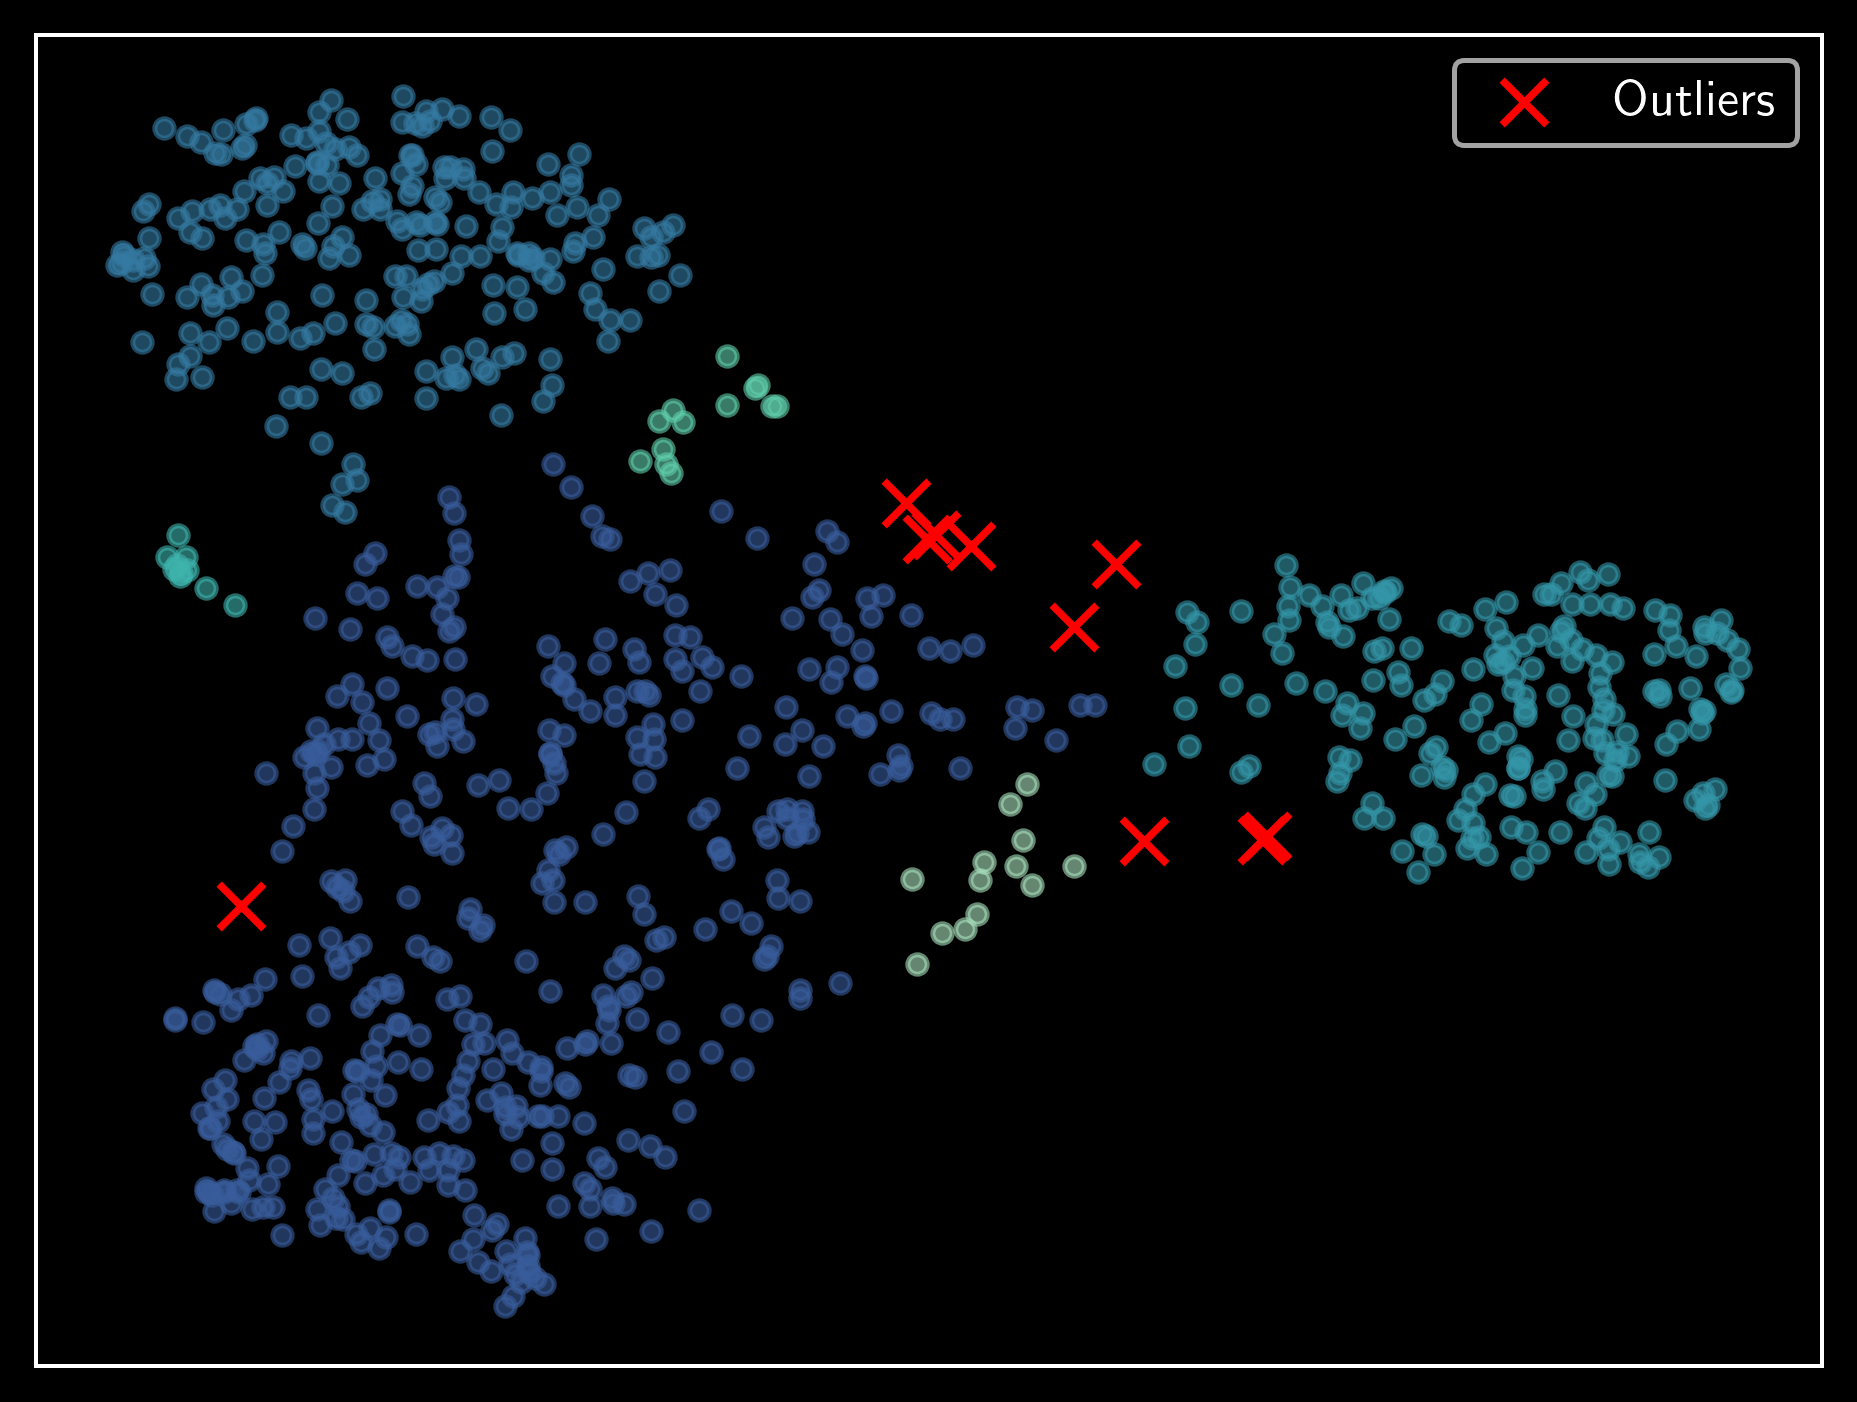

In [192]:
n_inliers = 500
n_features = 10
n_clusters = 3
cluster_std = 4.0  #std

X_inliers, _ = make_blobs(n_samples=n_inliers,
                          n_features=n_features,
                          centers=n_clusters,
                          cluster_std=cluster_std,)

n_outliers = 400
X_outliers = np.random.uniform(low=-20, high=20, size=(n_outliers, n_features))

X = np.vstack([X_inliers, X_outliers])

reducer = umap.UMAP()
embedding = reducer.fit_transform(X)

linking_length = 0.3

dist_matrix = distance_matrix(embedding, embedding)

adjacency = (dist_matrix < linking_length) & (dist_matrix > 0)

adjacency_sparse = csr_matrix(adjacency)

n_components, labels = connected_components(csgraph=adjacency_sparse, directed=False, return_labels=True)
print(f'clusters: {n_components}')

min_cluster_size = 10
unique_labels, counts = np.unique(labels, return_counts=True)
small_clusters = unique_labels[counts < min_cluster_size]

is_outlier = np.isin(labels, small_clusters)
unique_clusters = np.unique(labels[~is_outlier])
n_clusters = len(unique_clusters)

colors = [cmap(i / n_clusters) for i in range(n_clusters)]

plt.figure()

for i, cl in enumerate(np.unique(labels[~is_outlier])):
    mask = labels == cl
    plt.scatter(embedding[mask, 0], embedding[mask, 1], alpha=0.6, s=15, c=colors[i])#, label=f'Cluster {cl}',)

if np.sum(is_outlier) > 0:
    plt.scatter(embedding[is_outlier, 0], embedding[is_outlier, 1],
                color='red', marker='x', s=80, label='Outliers')

# plt.title('Random UMAP/FoF\n')
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()